## Math behind A/B testing

key points:

1. controlled test to seek impacts

In [1]:
bcr = 0.1 # baseline conversion rate
d_hat = 0.02 # diff btwn the groups

#### Control Group(A) and Test Group(B)

In [66]:
# generate data
import scipy.stats as scs
import pandas as pd
import numpy as np

# create group column
N_A = 1000
N_B = 1000
bern_group = scs.bernoulli(N_A / (N_A + N_B))
group = bern_group.rvs(2000)
# creat converted column
converted = []
for _ in range(len(group)):
    if group[_] == 0:
        converted.append(scs.bernoulli(bcr).rvs()) # FAKE CLICK THROUGH RATE
    else:
        converted.append(scs.bernoulli(bcr + d_hat).rvs()) # FAKE CLICK THROUGH RATE WITH DIFF OF 0.02
data = pd.DataFrame(list(zip(converted, group)),columns =['converted', 'group'])

In [67]:
data['group'] = data['group'].apply(lambda x : 'A' if x == 0 else 'B')
data

,converted,group
0,0,B
1,0,B
2,0,B
3,0,A
4,0,A
...,...,...
1995,1,B
1996,0,B
1997,0,A
1998,0,B


In [68]:
summary = data.pivot_table(values = 'converted', index = 'group', aggfunc = np.sum)
summary["total"] = [data.group.value_counts()['A'],data.group.value_counts()['B']]
summary["rate"] = summary["converted"]/summary["total"]

In [69]:
summary

,converted,total,rate
group,,,
A,88,975,0.090256
B,118,1025,0.115122


In [70]:
# calculate statistics

Ppool = (summary.converted.A + summary.converted.B) / (summary.total.A + summary.total.B)
SE = np.sqrt(Ppool * (1 - Ppool) * (1 / summary.total.A + 1 / summary.total.B))
conf = 1.96 * SE # 95% based on Gaussian distribution
conf

0.026651500337577665

In [71]:
- summary.rate.diff()

group
A         NaN
B   -0.024866
Name: rate, dtype: float64

\< 0.02665.. , statistically NOT significant

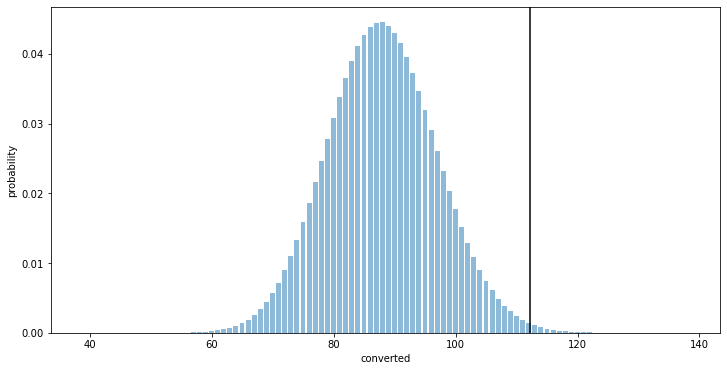

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,6))
x = np.linspace(summary.converted.A-49,summary.converted.A+50,100)
y = scs.binom(summary.total.A,summary.rate.A).pmf(x)
ax.bar(x,y,alpha = 0.5)
ax.axvline(summary.rate.B * summary.total.A, c='k', linestyle='-')
plt.xlabel('converted')
plt.ylabel('probability')
plt.show()